# Fair Data Adaptation
The `FairAdapt` package provides a pre-processing method that can be used with the following workflow (both regression and classification):
    
    1. obtain a dataset of interest (D),
    2. define the causal graph (G) for the dataset (see the graph of the Adult dataset below as an example),
    3. using original data D and the causal graph G obtain a fair-transformed version of the data FT(D),
    4. after the adaptation, use the transformed dataset FT(D) to train any classifier/regressor.
    
The adaptation procedure in `FairAdapt` adapts the variables in a topological order and ensures that discrimination removal is causally meaningful (under the assumption that the causal graph G is correctly specified). Additionally, the method explicitly computes what is known in the literature as _counterfactual instances_. For example, for a male individual, we can explicitly compute what his "education level or employment status would have been, had he in fact been female". Such reasoning can also help justify fair decision-making. 

In the following, we give an example of how `FairAdapt` can be used.

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import igraph

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.preprocessing import FairAdapt

## Load a dataset
We start by loading the UCI Adult dataset and inspecting it.

In [3]:
X, y, sample_weight = fetch_adult()
n_samp = 5000

X = X.drop(['education', 'capital-gain', 'capital-loss', 'relationship'], axis=1)
X = X[0:n_samp]
y = y[0:n_samp]

X.head()

,,,age,workclass,education-num,marital-status,occupation,race,sex,hours-per-week,native-country
,race,sex,,,,,,,,,
0,Non-white,Male,25.0,Private,7.0,Never-married,Machine-op-inspct,Non-white,Male,40.0,United-States
1,White,Male,38.0,Private,9.0,Married-civ-spouse,Farming-fishing,White,Male,50.0,United-States
2,White,Male,28.0,Local-gov,12.0,Married-civ-spouse,Protective-serv,White,Male,40.0,United-States
3,Non-white,Male,44.0,Private,10.0,Married-civ-spouse,Machine-op-inspct,Non-white,Male,40.0,United-States
5,White,Male,34.0,Private,6.0,Never-married,Other-service,White,Male,30.0,United-States


## Split the data into training and testing

In [4]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.8, random_state=1234567)

## Train a LGBM predictor on original data and compute accuracy and parity gap

In [5]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.835

In [6]:
# parity gap
par_gap = statistical_parity_difference(y_test, y_pred, prot_attr="sex", 
                                         priv_group="Male", pos_label=">50K")
print(f"Parity gap equals {par_gap:.2%}")

Parity gap equals -20.00%


Therefore, a male person is 20\% more likely than a female person to be predicted as earning more than 50k$/year.

## Construct the adjacency matrix (causal graph)

In [7]:
# construct an adjacency matrix
train_df = pd.concat([X_train, y_train], axis=1)
adj_mat = pd.DataFrame(
    np.zeros((len(train_df.columns), len(train_df.columns)), dtype=int),
    index=train_df.columns.values,
    columns=train_df.columns.values
)

# Construct the adjacency matrix of the causal graph
adj_mat.loc[["sex", "age", "native-country", "race"],
            ["marital-status", "education-num","workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc["marital-status",
            ["education-num", "workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc["education-num",
            ["workclass", "hours-per-week", "occupation", "annual-income"]] = 1
adj_mat.loc[["workclass", "hours-per-week", "occupation"],
            "annual-income"] = 1

## Visualize the causal graph
After constructing the causal model for the Adult dataset, we can visualize what it looks like:

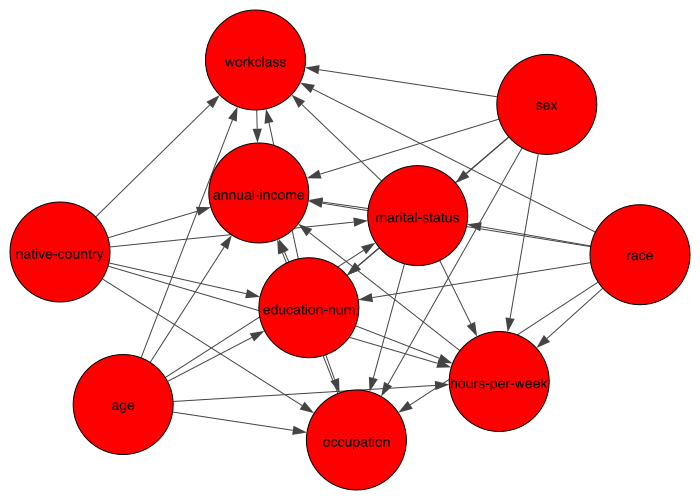

In [8]:
G = igraph.Graph.Adjacency(matrix=adj_mat.values.tolist())
G.vs['label'] = adj_mat.columns
igraph.plot(G, bbox=(0, 0, 700, 500), vertex_size=100, margin=60)

## Instantiate and run FairAdapt
In the final step we run `FairAdapt` to perform the data adaptation. We use sex as the protected attribute.

In [9]:
FA = FairAdapt(prot_attr="sex", adj_mat=adj_mat)
Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)

## Retrain LGBM and check whether discrimination was removed
After the adaptation, the same classifier is used again, but on the fair version of the data.

In [10]:
clf_fair = LGBMClassifier()
clf_fair.fit(Xf_train, yf_train)

yf_pred = clf_fair.predict(Xf_test)
accuracy_score(y_test, yf_pred)

0.779

In [11]:
# fair parity gap
fair_gap = statistical_parity_difference(y_test, yf_pred, prot_attr="sex", 
                                         priv_group="Male", pos_label=">50K")
print(f"Fair parity gap equals {fair_gap:.2%}")

Fair parity gap equals -4.17%


After applying `FairAdapt`, we notice that the parity gap between the group was decreased.